## [Introduction to Pyro](http://pyro.ai/examples/intro_long.html#Introduction-to-Pyro)

In [ ]:
%reset -s -f

In [1]:
import logging
import os

In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pyro

In [4]:
assert pyro.__version__.startswith('1.8')

In [5]:
pyro.enable_validation(True)
pyro.set_rng_seed(234)

In [6]:
logging.basicConfig(format='%(message)s', level=logging.INFO)

In [7]:
%matplotlib inline
plt.style.use(style='ggplot')

___

Most data analysis problems can be understood as elaborations on three basic high-level questions:

- What do we know about the problem before observing any data?

- What conclusions can we draw from data given our prior knowledge?

- Do these conclusions make sense?

In the probabilistic or Bayesian approach to data science and machine learning, we formalize these in terms of mathematical operations on probability distributions.

$$p_{\theta}({\bf z} | {\bf x}) = \frac{p_{\theta}({\bf x} , {\bf z})}{
\int \! d{\bf z}\; p_{\theta}({\bf x} , {\bf z}) }$$

Marginal Likelihood or Evidence$$p_{\theta}({\bf x}) = \int \! d{\bf z}\; p_{\theta}({\bf x} , {\bf z})$$

$$\theta_{\rm{max}} = \rm{argmax}_\theta p_{\theta}({\bf x}) = \rm{argmax}_\theta \int \! d{\bf z}\; p_{\theta}({\bf x} , {\bf z})$$

___

In [8]:
data_url = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"

In [9]:
data = pd.read_csv(data_url, encoding='ISO-8859-1')

In [10]:
data.columns

Index(['isocode', 'isonum', 'country', 'rugged', 'rugged_popw', 'rugged_slope',
       'rugged_lsd', 'rugged_pc', 'land_area', 'lat', 'lon', 'soil', 'desert',
       'tropical', 'dist_coast', 'near_coast', 'gemstones', 'rgdppc_2000',
       'rgdppc_1950_m', 'rgdppc_1975_m', 'rgdppc_2000_m', 'rgdppc_1950_2000_m',
       'q_rule_law', 'cont_africa', 'cont_asia', 'cont_europe', 'cont_oceania',
       'cont_north_america', 'cont_south_america', 'legor_gbr', 'legor_fra',
       'legor_soc', 'legor_deu', 'legor_sca', 'colony_esp', 'colony_gbr',
       'colony_fra', 'colony_prt', 'colony_oeu', 'africa_region_n',
       'africa_region_s', 'africa_region_w', 'africa_region_e',
       'africa_region_c', 'slave_exports', 'dist_slavemkt_atlantic',
       'dist_slavemkt_indian', 'dist_slavemkt_saharan', 'dist_slavemkt_redsea',
       'pop_1400', 'european_descent'],
      dtype='object')

In [11]:
df = data[['cont_africa', 'rugged', 'rgdppc_2000']]

In [12]:
df = df[np.isfinite(df.rgdppc_2000)]

In [13]:
df['log_rgdppc_2000'] = np.log(df.rgdppc_2000)

In [14]:
train = torch.tensor(df.values, dtype=torch.float)

In [15]:
train.shape

torch.Size([170, 4])

In [16]:
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

In [17]:
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]

[Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 1.0, 'African Nations')]

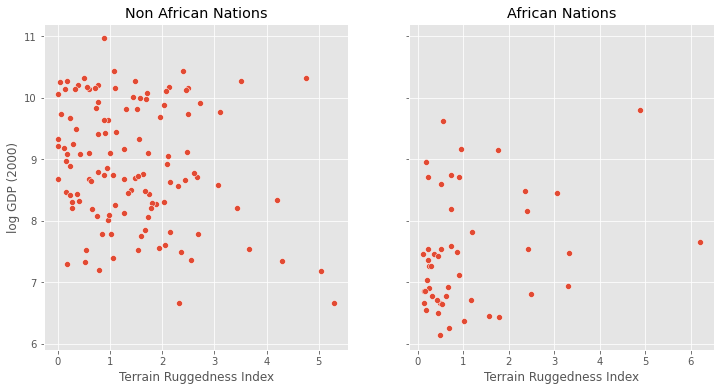

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["log_rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")

sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["log_rgdppc_2000"],
                ax=ax[1])

ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

Probabilistic models in Pyro are specified as Python functions model(*args, **kwargs) that generate observed data from latent variables using special primitive functions whose behavior can be changed by Pyro’s internals depending on the high-level computation being performed.

Specifically, the different mathematical pieces of model() are encoded via the mapping:

1. latent random variables $z \Longleftrightarrow$  pyro.sample

2. observed random variables $y \Longleftrightarrow$  pyro.sample with the obs keyword argument

3. learnable parameters $\theta \Longleftrightarrow$  pyro.param

4. plates $\Longleftrightarrow$ pyro.plate context managers

In [19]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

In [20]:
def reg_model(is_cont_africa, ruggedness, log_gdp=None):
    alpha = pyro.param("alpha", lambda: torch.randn(()))
    beta_A = pyro.param("beta_a", lambda: torch.randn(()))
    beta_R = pyro.param("beta_r", lambda: torch.randn(()))
    beta_AR = pyro.param("beta_ar", lambda: torch.randn(()))
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)

    mu = alpha + beta_A * is_cont_africa + beta_R * ruggedness + beta_AR * is_cont_africa * ruggedness

    with pyro.plate("observations", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mu, sigma), obs=log_gdp)

In [21]:
pyro.render_model(
                    reg_model, 
                    model_args=(is_cont_africa, ruggedness, log_gdp), 
                    render_distributions=True, 
                    render_params=True
                    )

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [22]:
%%time

pyro.clear_param_store()

auto_guide = pyro.infer.autoguide.AutoNormal(reg_model)
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()

svi = pyro.infer.SVI(reg_model, auto_guide, adam, elbo)

losses = []

for step in range(1000):
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 ==0:
        logging.info("Elbo loss is {}".format(loss))

Elbo loss is 14987826176.0
Elbo loss is 1445723520.0
Elbo loss is 609114880.0
Elbo loss is 350887616.0
Elbo loss is 232957792.0
Elbo loss is 167874416.0
Elbo loss is 127620152.0
Elbo loss is 100740432.0
Elbo loss is 81774064.0
Elbo loss is 67823016.0


CPU times: user 1.76 s, sys: 9.99 ms, total: 1.77 s
Wall time: 1.76 s


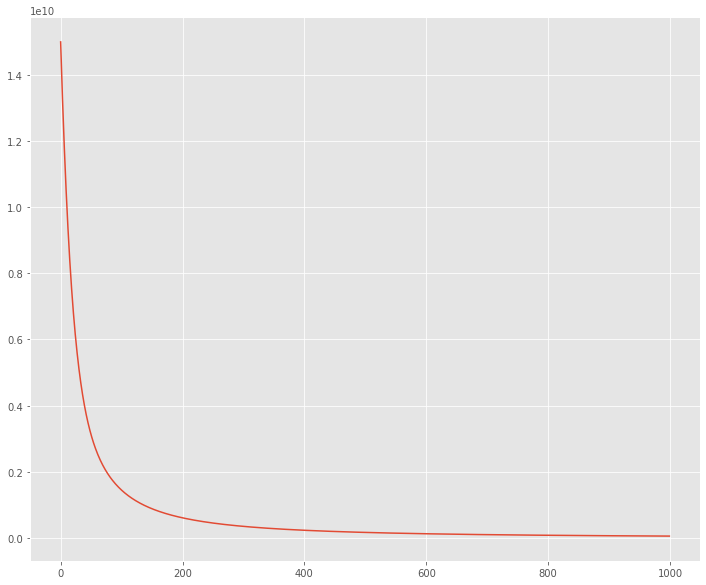

In [23]:
plt.figure(figsize=(12,10))
plt.plot(losses)